In [1]:
## modify these parameters
fname = 'data/3_9eq_03_02_2022_-25_005.mp4'

# set to -1 to store one image per minute
store_every = -1
store_every = 100

# set to -1 to read all of the images
max_images_to_read = -1
max_images_to_read = 10000

In [2]:
## don't modify below here, just execute

In [3]:
!pwd

/Users/ericdill/dev/jdm/liquid-crystal


In [4]:
import pathlib
fname = pathlib.Path(fname)
if not fname.exists():
    raise RuntimeError(f"Cannot find {fname}")

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import textwrap
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import traitlets

import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from ipywidgets import interactive
import datetime

In [24]:
%matplotlib widget

In [25]:
class VideoData(traitlets.HasTraits):
    filename = traitlets.Any()
    # Store every how many frames?
    store_every = traitlets.Integer(default_value=-1)
    # How many images should we ready into memory?
    max_images_to_read = traitlets.Integer(default_value=-1)
    
    # parameters automatically managed by the class, don't set
    _vid = traitlets.Any()
    # _data = traitlets.Any()
    _fps = traitlets.Float()
    _frame_count = traitlets.Integer()
    _duration = traitlets.Float()
    _width = traitlets.Integer()
    _height = traitlets.Integer()
    _images_to_store = traitlets.Integer()
    _time_between_stored_images = traitlets.Float()
    
    def __init__(self):
        # write up interactivity
        self.observe(self._new_params)
        self._data = None
    
    def _parse_vid_metadata(self):
        if self._vid is None:
            return
        self._fps = self._vid.get(cv2.CAP_PROP_FPS)
        self._frame_count = int(self._vid.get(cv2.CAP_PROP_FRAME_COUNT))
        self._duration = self._frame_count/self._fps
        self._width = int(self._vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._height = int(self._vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        if self.store_every == -1:
            self.store_every = int(np.ceil(self._fps))
        if self.max_images_to_read == -1:
            self.max_images_to_read = self._frame_count
        
        self._images_to_store = self.max_images_to_read // self.store_every
        self._time_between_stored_images = self.store_every / self._fps
    
    def md(self):
        all_traits = self.traits()
        del all_traits['_vid']
        d = {k: getattr(self, k) for k, v in all_traits.items()}
        return d
    
    def _init_data(self):
        self._data = np.zeros((self._images_to_store+1, self._height, self._width), dtype=np.uint8)
    
    def _open(self):
        self._vid = cv2.VideoCapture(str(self.filename))
        
    def _new_params(self, update):
        print(update)
        if update['name'] == 'filename':
            self._open()
        if update['name'] in ('_vid', 'store_every', 'max_images_to_read'):
            # parse the video metadata
            self._parse_vid_metadata()
            # self._init_data()
            
    def total_time(self):
        seconds=int(self._frame_count / self._fps)
        total_time = str(datetime.timedelta(seconds=seconds))
        return seconds, f"Movie duration: {total_time} (HH:MM:SS)"

    def index_metadata(self, idx):
        seconds = idx * self.store_every / self._fps
        dt = str(datetime.timedelta(seconds=seconds))
        index = idx * self.store_every
        return {'image_timestamp': dt, 'actual_image_index': index}

    def read(self, callback=None, store_data=True):
        """Read in video frames up to `self.max_images_to_read` but only save every `self.store_every` in memory"""
        # reset back to start of video
        self._open()
        # print out a message to the user letting them know what's about to happen
        message = f"Reading in {self.max_images_to_read} frames and "
        if store_data:
            message += (f'storing one frame every {self.store_every} frames. '
                        f"This corresponds to one frame every {self._time_between_stored_images} second(s) "
                        f"and {self._images_to_store} images will be stored in total.")
        else:
            message += 'not storing any frames because store_data=False. '
        print(message)
        for idx in trange(self.max_images_to_read-1):
            # read in an image
            ret, frame = self._vid.read()
            if not ret:
                # no more frames to read
                break
            # convert it to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if callback:
                # this callback is used to inject some analytics into the middle of the read
                # without having to write new code to do so
                callback(gray, idx)
            if idx % self.store_every == 0 and store_data:
                # store the data if the user has asked us to do so
                if self._data is None:
                    self._init_data()
                self._data[idx // self.store_every] = gray
            
        

In [14]:
v = VideoData()
v.store_every = 100
v.max_images_to_read = 10000
v.filename = fname
v.index_metadata(1), v.index_metadata(10)

{'name': 'store_every', 'old': -1, 'new': 100, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': 'max_images_to_read', 'old': -1, 'new': 10000, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': 'filename', 'old': None, 'new': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_vid', 'old': None, 'new': < cv2.VideoCapture 0x13576f8d0>, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_fps', 'old': 0.0, 'new': 13.12227601566946, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_frame_count', 'old': 0, 'new': 24780, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_duration', 'old': 0.0, 'new': 1888.3919199999998, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_width', 'old': 0, 'new': 1920, 'owner': <__main__.VideoData objec

({'image_timestamp': '0:00:07.620629', 'actual_image_index': 100},
 {'image_timestamp': '0:01:16.206292', 'actual_image_index': 1000})

In [ ]:
v.read()

{'name': '_vid', 'old': < cv2.VideoCapture 0x13576f8d0>, 'new': < cv2.VideoCapture 0x1035b3230>, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
Reading in 10000 frames and storing one frame every 100 frames. This corresponds to one frame every 7.620629217110572 second(s) and 100 images will be stored in total.


  0%|          | 0/9999 [00:00<?, ?it/s]

Text(0, 0.5, 'total image intensity')

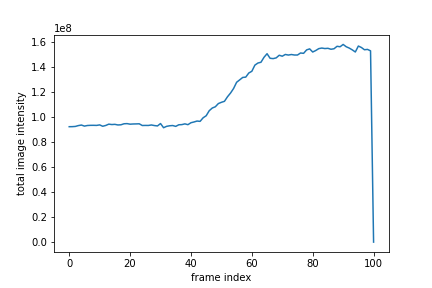

In [26]:
## Plot summed intensity over time
I = np.sum(v._data, axis=(1,2))
fig, ax = plt.subplots()
lines = ax.plot(I)
ax.set_xlabel("frame index")
ax.set_ylabel("total image intensity")

In [27]:
def imshow_with_patches(ax, data, patches: dict):
    try:
        im = ax.images[-1]
    except IndexError:
        print("No image currently show. calling ax.imshow")
        im = ax.imshow(data)
    else:
        im.set_data(data)
    
    print(f"Removing {len(ax.patches)} existing patches")
    
    for existing_patch in ax.patches:
        existing_patch.remove()
    added_patches = {}
    for patch_name, patch in patches.items():
        print(f"Adding patch for {patch_name}")
        added_patches[patch_name] = ax.add_patch(patch)
    return im, added_patches
    
class VideoScrubber(traitlets.HasTraits):
    video_data = traitlets.Any()
    
    def __init__(self):
        self.slider = widgets.IntSlider()
        self.timestamp = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.plot = widgets.Output()
        # Init the matplotlib plot
        self.fig, self.ax = plt.subplots()
        self.patches = {}
        
        # Define the layout
        with self.plot:
            plt.show(self.fig)

        # interactive_plot = interactive(self._plotter, idx=self.slider)
        # interact(self._plotter, frame_idx=self.slider)
        
        self.layout = widgets.VBox([
            self.slider,
            self.plot,
            self.timestamp, 
            self.actual_frame,
        ])
        
        # display(self.layout)
        
        # wire up interactivity
        
        self.observe(self._updater_callback)
        self.slider.observe(self._plotter_callback, names=['value'])
        
    
    def _update_plot(self, frame_idx):
        if self.video_data is None:
            return
        print(frame_idx)
        # return
        data = self.video_data._data[frame_idx]
        imshow_with_patches(self.ax, data, self.patches)
        # Get previous zoom
        self.fig.canvas.draw_idle()
        md = v.index_metadata(frame_idx)
        self.timestamp.value = md['image_timestamp']
        self.actual_frame.value = str(md['actual_image_index'])
        #TODO Update other text boxes
    
    def _draw_patches(self):
        patches = self.patches
        frame_idx = self.slider.value
        self._update_plot(frame_idx)
        
    def _plotter_callback(self, update):
        frame_idx = update['new']
        self._update_plot(frame_idx)
        
    def _updater_callback(self, update):
        print(update)
        if update['name'] == 'video_data':
            md = self.video_data.md()
            print(md)
            

In [28]:
vs = VideoScrubber()
vs.video_data = v

display(vs.layout)


{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x1353db8b0>, 'owner': <__main__.VideoScrubber object at 0x1359a91b0>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 100, '_time_between_stored_images': 7.620629217110572, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 10000, 'store_every': 100}


In [29]:
import ipywidgets

In [30]:
import some_math

In [31]:
import importlib
importlib.reload(some_math)
import some_math

In [32]:
class UI(traitlets.HasTraits):
    frame_idx = traitlets.Integer()
    # video_data = traitlets.Any()
    lines = traitlets.List()
    
    def __init__(self):
        self.add_line_button = widgets.Button(description="Add Line")
        self.textbox = widgets.Text(description="HH:MM:SS")
        self.actual_frame = widgets.Text(description="actual frame")
        self.video_scrubber = VideoScrubber()
        self.plot = widgets.Output()
        self.slider = widgets.IntSlider()
        self.line_patches = {}
        
        # Wire up interactivity
        self.add_line_button.on_click(self._on_click)
        # self.observe(self._new_data, names=['video_data'])
        
        # Do the displaying stuff
        self.line_layout = widgets.VBox([self.add_line_button])
        with self.plot:
            plt.show(self.fig)
            
        self.layout = widgets.HBox([
            self.video_scrubber.layout,
            self.line_layout,
        ])
        display(self.layout)
        
        
    def _on_click(self, b):
        print(b)
        lf = some_math.LinearFace()
        lf.callback=self._update_line_data_callback
        self.lines.append(lf)
        self.line_layout.children = [_.layout for _ in self.lines] + [self.add_line_button]
        
    # def _new_data(self, data):
    #     print(data)
    #     print(self.video_data)
    #     self.ax.imshow(self.video_data._data[0])
    #     self.fig.canvas.draw()
        
    def _update_line_data_callback(self, obj):
        print(f'received update for {obj.name}')
        x0,y0 = obj.p1.x, obj.p1.y
        width = float(obj.width.value)
        height = float(obj.height.value)
        color = obj.color_picker.value
        th_deg = obj.rect_angle
        print(f'rectangle info: x0={x0},y0={y0},width={width},height={height},th_deg={th_deg},color={color}')
        patch = some_math.mpl_rect_patch(
            x=x0, y=y0, width=width, height=height, color=color,
            axes=self.video_scrubber.ax, rot=th_deg
        )
        self.line_patches[obj.name.value] = patch
        self.video_scrubber.patches = self.line_patches
        self.video_scrubber._draw_patches()
        
        
        

ui = UI()
ui.video_scrubber.video_data = v

{'name': 'video_data', 'old': None, 'new': <__main__.VideoData object at 0x1353db8b0>, 'owner': <__main__.VideoScrubber object at 0x137ab40a0>, 'type': 'change'}
{'_duration': 1888.3919199999998, '_fps': 13.12227601566946, '_frame_count': 24780, '_height': 1200, '_images_to_store': 100, '_time_between_stored_images': 7.620629217110572, '_width': 1920, 'filename': PosixPath('data/3_9eq_03_02_2022_-25_005.mp4'), 'max_images_to_read': 10000, 'store_every': 100}


In [33]:
class Outputter:
    def __init__(self, num_frames, patch, name):
        self.patch = patch
        self.num_frames = num_frames
        self.name = name
        # will be set on init_output
        self.mask = None     
        self.output_data = None
        self.num_pixels = None
    
    def init_output(self, image):
        self.mask = some_math.make_image_mask(image, self.patch)
        self.num_pixels = len(self.mask[self.mask])
        self.output_data = np.zeros(shape=(self.num_frames, self.num_pixels))
        
    def reader_callback(self, image, image_idx):
        # print('in callback')
        if self.mask is None:
            self.init_output(image)
            self.x, self.y, _ = some_math.extract_pixels_xyi(image, self.patch)
        
        I = image[self.mask]
        self.output_data[image_idx] = I
        
            
            

In [34]:
num_frames = v._frame_count
outputters = [Outputter(num_frames, patch, name=patch_name) for patch_name, patch in sorted(ui.video_scrubber.patches.items())]

In [35]:
def reader_callback(image, image_idx):
    for outputter in outputters:
        outputter.reader_callback(image, image_idx)

In [36]:
v._open()
v.max_images_to_read=-1
v.read(callback=reader_callback, store_data=False)

{'name': '_vid', 'old': < cv2.VideoCapture 0x1035b3230>, 'new': < cv2.VideoCapture 0x1410a4dd0>, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': 'max_images_to_read', 'old': 10000, 'new': -1, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': 'max_images_to_read', 'old': -1, 'new': 24780, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_images_to_store', 'old': 100, 'new': 247, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
{'name': '_vid', 'old': < cv2.VideoCapture 0x1410a4dd0>, 'new': < cv2.VideoCapture 0x1410a4650>, 'owner': <__main__.VideoData object at 0x1353db8b0>, 'type': 'change'}
Reading in 24780 frames and not storing any frames because store_data=False. 


  0%|          | 0/24779 [00:00<?, ?it/s]

In [37]:
outputter = outputters[0]
outputter.output_data

array([[50., 50., 50., ..., 48., 48., 48.],
       [50., 50., 50., ..., 48., 48., 48.],
       [50., 50., 50., ..., 48., 48., 48.],
       ...,
       [63., 63., 65., ..., 55., 55., 55.],
       [63., 63., 65., ..., 55., 55., 55.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

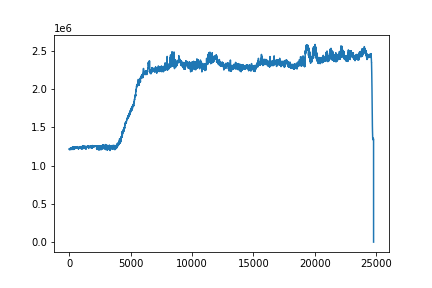

In [42]:
outputter.output_data.shape

i = outputter.output_data.sum(axis=1)

fig, ax = plt.subplots()
ax.plot(i)

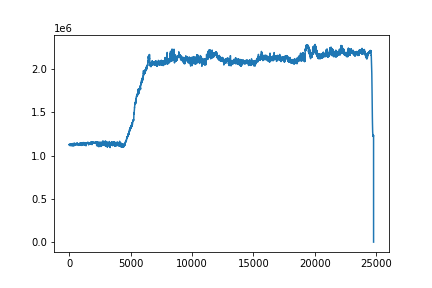

In [43]:
outputter = outputters[1]
outputter.output_data.shape

i = outputter.output_data.sum(axis=1)

fig, ax = plt.subplots()
ax.plot(i)

1. threshold the individual rectangles to determine is crystal or isnt crystal
2. then get the percentage of the rectangle that is crystal
3. then percentage times length and convert to distance